<a href="https://colab.research.google.com/github/Spica08/deep-learning-from-scratch-5/blob/main/step9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# set up
import os
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

import torch
from torch import nn

from torchvision import datasets, transforms

In [19]:
#データ準備
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# step9 拡散モデルの実装

## 9.1 U-Net
8.6.4で見たように、拡散モデルで使用されるニューラルネットワークは、数式では$\epsilon_\theta(x_t, t)$と表される。このニューラルネットワークは$x_t$を生成する際に加えられたノイズを予測する。  

このニューラルネットワークの入力は$x_t$とtの2つである。まずはtを省略したモデルを作成し、続いて時刻を加えたモデルを実装する。  

拡散モデルで用いるモデルは、入力と出力の形状が同じ必要がある。この要件を満たすモデルはAutoEncoderやFCNなどが挙げられ。拡散モデルではU-Netがよく使用される。

### 9.1.1 U-Netとは
略

### 9.1.2 U-Netの実装
MNISTデータセットを利用したシンプルなU-Netの実装を行う。  

まず、ConvBlock(convolution -> batch normalization -> ReLUを2層)を実装する。

In [2]:
# make convolutional block
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.convs(x)
        return x

続いてUNet

In [3]:
# make U-Net
class UNet(nn.Module):
    def __init__(self, in_ch = 1):
        super().__init__()

        self.down1 = ConvBlock(in_ch, 64)
        self.down2 = ConvBlock(64, 128)
        self.bot1 = ConvBlock(128, 256)
        self.up2 = ConvBlock(128 + 256, 128)
        self.up1 = ConvBlock(128 + 64, 64)
        self.out = nn.Conv2d(64, in_ch, kernel_size = 3, padding = 1)

        self.maxpool = nn.MaxPool2d(2) # strideのデフォルトはkernel_size
        self.upsample = nn.Upsample(scale_factor = 2, mode = "bilinear")

    # x.shape -> (B, 1, 28, 28)
    def forward(self, x):
        x1 = self.down1(x) # -> (B, 64, 28, 28)
        x = self.maxpool(x1) # -> (B, 64, 14, 14)
        x2 = self.down2(x) # -> (B, 128, 14, 14)
        x = self.maxpool(x2) # -> (B, 128, 7, 7)

        x = self.bot1(x) # -> (B, 256, 7, 7)

        x = self.upsample(x) # -> (B, 256, 14, 14)
        x = torch.cat([x, x2], dim = 1) # -> (B, 128 + 256, 14, 14)
        x = self.up2(x) # -> (B, 128, 14, 14)
        x = self.upsample(x) # -> (B, 128, 28, 28)
        x = torch.cat([x, x1], dim = 1) # -> (B, 128 + 64, 28, 28)
        x = self.up1(x) # -> (B, 64, 28, 28)
        x = self.out(x) # -> (B, 1, 28, 28)
        return x


In [4]:
# check model
model = UNet()
x = torch.randn(10, 1, 28, 28)
y = model(x)
print(y.shape)

torch.Size([10, 1, 28, 28])


## 9.2 正弦波位置エンコーディング
$x_t$を処理するU-Netが実装できたので、時刻tの情報を取り入れるようにすれば良い。拡散モデルではtの情報のエンコーディングにしばしば正弦波エンコーディングが用いられる。

### 9.2.1 正弦波位置エンコーディングとは
正弦波位置エンコーディングでは、正弦波(サイン波)を使って位置情報をエンコーディングする。  
整数tをベクトルvへと変換するとき、変換後のベクトルの次元数をDとするとi番目の要素は以下のように表される。  
\begin{equation}
v_i =
    \begin{cases}
        sin{\left(\frac{t}{10000^{\frac{i}{D}}}\right)} & iが偶数\\
        cos{\left(\frac{t}{10000^{\frac{i}{D}}}\right)} & iが奇数
    \end{cases}
\end{equation}
位置情報を絶対的な値ではなく周期的な特性を持つ三角関数を通じてエンコードする。これにより、位置情報の相対的な差異や周期的なパターンが明確に表現でき、モデルは系列データ中の相対位置の関係性をより効果的に学習できるようになる。

### 9.2.2 正弦波位置エンコーディングの実装

In [5]:
# encode 1 time point
def _pos_encoding(t, output_dim, device = 'cpu'):
    D = output_dim
    v = torch.zeros(D, device = device)

    i = torch.arange(0, D, device = device)
    div_term = 10000 ** (i / D)

    v[0::2] = torch.sin(t / div_term[0::2])
    v[1::2] = torch.cos(t / div_term[1::2])
    return v

In [6]:
print(_pos_encoding(1, 16))
print(_pos_encoding(1, 16).shape)

tensor([8.4147e-01, 8.4601e-01, 3.1098e-01, 9.8423e-01, 9.9833e-02, 9.9842e-01,
        3.1618e-02, 9.9984e-01, 9.9998e-03, 9.9998e-01, 3.1623e-03, 1.0000e+00,
        1.0000e-03, 1.0000e+00, 3.1623e-04, 1.0000e+00])
torch.Size([16])


In [7]:
# encode multiple time point
def pos_encoding(ts, output_dim, device = 'cpu'):
    batch_size = len(ts)
    v = torch.zeros(batch_size, output_dim, device = device)

    for i, t in enumerate(ts):
        v[i] = _pos_encoding(t, output_dim, device)
    return v

In [8]:
v = pos_encoding(torch.tensor([1, 2, 3]), 16)
print(v)
print(v.shape)

tensor([[ 8.4147e-01,  8.4601e-01,  3.1098e-01,  9.8423e-01,  9.9833e-02,
          9.9842e-01,  3.1618e-02,  9.9984e-01,  9.9998e-03,  9.9998e-01,
          3.1623e-03,  1.0000e+00,  1.0000e-03,  1.0000e+00,  3.1623e-04,
          1.0000e+00],
        [ 9.0930e-01,  4.3146e-01,  5.9113e-01,  9.3742e-01,  1.9867e-01,
          9.9368e-01,  6.3203e-02,  9.9937e-01,  1.9999e-02,  9.9994e-01,
          6.3245e-03,  9.9999e-01,  2.0000e-03,  1.0000e+00,  6.3246e-04,
          1.0000e+00],
        [ 1.4112e-01, -1.1597e-01,  8.1265e-01,  8.6104e-01,  2.9552e-01,
          9.8580e-01,  9.4726e-02,  9.9858e-01,  2.9995e-02,  9.9986e-01,
          9.4867e-03,  9.9999e-01,  3.0000e-03,  1.0000e+00,  9.4868e-04,
          1.0000e+00]])
torch.Size([3, 16])


### 9.2.3 U-Netに組み込む
ConvBlockに正弦波位置エンコーディングの情報を追加する。位置エンコーディング用のベクトルはD次元なので、MLP層で次元数を調整してデータと加算する。

In [16]:
# make convolutional block with positional encoding
class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, time_embed_dim):
        super().__init__()
        self.convs = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU()
        )
        self.mlp = nn.Sequential(
            nn.Linear(time_embed_dim, in_ch),
            nn.ReLU(),
            nn.Linear(in_ch, in_ch)
        )

    def forward(self, x, v):
        N, C, _ = x.shape
        v = self.mlp(v)
        v = v.view(N, C, 1, 1)
        y = self.convs(x + v)
        return y

In [17]:
# make U-Net
class UNet(nn.Module):
    def __init__(self, in_ch = 1, time_embed_dim = 100):
        super().__init__()

        self.down1 = ConvBlock(in_ch, 64, time_embed_dim = time_embed_dim)
        self.down2 = ConvBlock(64, 128, time_embed_dim = time_embed_dim)
        self.bot1 = ConvBlock(128, 256, time_embed_dim = time_embed_dim)
        self.up2 = ConvBlock(128 + 256, 128, time_embed_dim = time_embed_dim)
        self.up1 = ConvBlock(128 + 64, 64, time_embed_dim = time_embed_dim)
        self.out = nn.Conv2d(64, in_ch, kernel_size = 3, padding = 1)

        self.maxpool = nn.MaxPool2d(2) # strideのデフォルトはkernel_size
        self.upsample = nn.Upsample(scale_factor = 2, mode = "bilinear")

    # x.shape -> (B, 1, 28, 28)
    def forward(self, x, timesteps):
        v = pos_encoding(timesteps, self.timesteps, x.device)

        x1 = self.down1(x, v)# -> (B, 64, 28, 28)
        x = self.maxpool(x1) # -> (B, 64, 14, 14)
        x2 = self.down2(x, v) # -> (B, 128, 14, 14)
        x = self.maxpool(x2) # -> (B, 128, 7, 7)

        x = self.bot1(x, v) # -> (B, 256, 7, 7)

        x = self.upsample(x) # -> (B, 256, 14, 14)
        x = torch.cat([x, x2], dim = 1) # -> (B, 128 + 256, 14, 14)
        x = self.up2(x, v) # -> (B, 128, 14, 14)
        x = self.upsample(x) # -> (B, 128, 28, 28)
        x = torch.cat([x, x1], dim = 1) # -> (B, 128 + 64, 28, 28)
        x = self.up1(x, v) # -> (B, 64, 28, 28)
        x = self.out(x) # -> (B, 1, 28, 28)
        return x

## 9.3 拡散過程

### 9.3.1 $q(x_t | x_t - 1)$からのサンプリング
拡散モデルの$q(x_t | x_t - 1)$は
\begin{equation}
q(x_t | x_{t - 1}) = \mathcal{N}(x_t;\sqrt{1 - \beta_t}x_{t - 1}, \beta_tI)
\end{equation}
このサンプリングを変数変換トリックを使用して表すと、
\begin{align}
\epsilon &\backsim \mathcal{N}(\epsilon_t;0, I)\\
x_t &= \sqrt{1 - \beta_t}x_{t - 1} + \sqrt{\beta_t}\epsilon
\end{align}
これを実装する

In [18]:
x = torch.randn(3, 64, 64) # dummy data
T = 1000
betas = torch.linspace(0.0001, 0.02, T)

for t in range(T):
    eps = torch.randn_like(x)
    x = torch.sqrt(1 - betas[t]) * x + torch.sqrt(betas[t]) * eps

### 9.3.2 画像に対する拡散過程
実際の画像データに対して拡散過程を実装する。

In [30]:
# load image
file_path = "/content/drive/MyDrive/datasets/flower.png"
image = plt.imread(file_path)
print(image.shape)

preprocess = transforms.ToTensor()
x = preprocess(image)
print(x.shape)

(64, 64, 3)
torch.Size([3, 64, 64])


In [23]:
# tensor to png
def reverse_to_img(x):
    x = x * 255
    x = x.clamp(0, 255)
    x = x.to(torch.uint8)
    to_pil = transforms.ToPILImage()
    return to_pil(x)

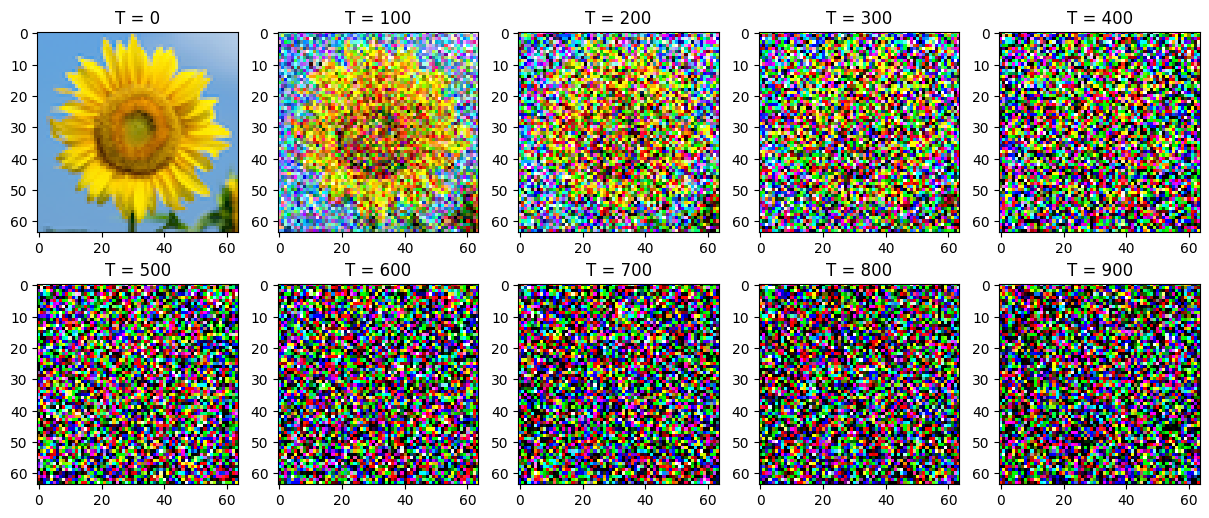

In [31]:
T = 1000
beta_start = 0.0001
beta_end = 0.02
betas = torch.linspace(beta_start, beta_end, T)
imgs = []

for t in range(T):
    if t % 100 == 0:
        img = reverse_to_img(x)
        imgs.append(img)

    eps = torch.randn_like(x)
    x = torch.sqrt(1 - betas[t]) * x + torch.sqrt(betas[t]) * eps

fig, axes = plt.subplots(figsize = (15, 6), ncols = 5, nrows = 2)
for i, (ax, img) in enumerate(zip(axes.ravel(), imgs)):
    ax.imshow(img)
    ax.set_title(f'T = {i * 100}')
